In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
from os.path import isfile, join

%matplotlib inline

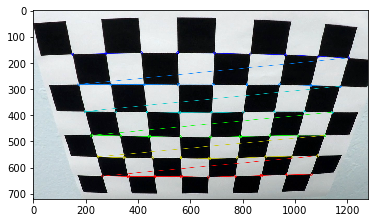

In [3]:
# prepare object points
nx = 9
ny = 6
nyx = (9, 6)

def plot_chessboard_corners():
    # Make a list of calibration images
    fname = 'camera_cal/calibration2.jpg'
    img = cv2.imread(fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If found, draw corners
    if ret == True:
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        plt.imshow(img)
        plt.show

plot_chessboard_corners()

In [4]:
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    return undist

#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
#f.tight_layout()
#ax1.imshow(img)
#ax1.set_title('Original Image', fontsize=50)
#ax2.imshow(undistorted)
#ax2.set_title('Undistorted Image', fontsize=50)
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

./camera_cal/calibration6.jpg
./camera_cal/calibration10.jpg
./camera_cal/calibration2.jpg
./camera_cal/calibration8.jpg
./camera_cal/calibration1.jpg
./camera_cal/calibration13.jpg
./camera_cal/calibration9.jpg
./camera_cal/calibration20.jpg
./camera_cal/calibration16.jpg
./camera_cal/calibration5.jpg
./camera_cal/calibration19.jpg
./camera_cal/calibration18.jpg
./camera_cal/calibration7.jpg
./camera_cal/calibration14.jpg
./camera_cal/calibration15.jpg
./camera_cal/calibration11.jpg
./camera_cal/calibration3.jpg
./camera_cal/calibration17.jpg
./camera_cal/calibration12.jpg
./camera_cal/calibration4.jpg


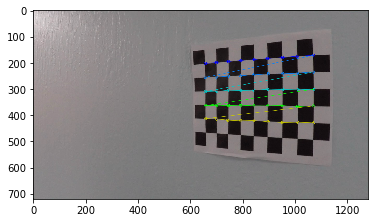

In [5]:
def extract_img_obj_points(nx, ny):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    mypath = "./camera_cal"

    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

    # Step through the list and search for chessboard corners
    for file in onlyfiles:
        final_path = mypath + '/' + file
        img = cv2.imread(final_path)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        print(final_path)
        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9, 5), corners, ret)
            plt.imshow(img)
    return objpoints, imgpoints

objpoints, imgpoints = extract_img_obj_points(nx, ny)

In [ ]:
#undistorted = cal_undistort(img, objpoints, imgpoints)

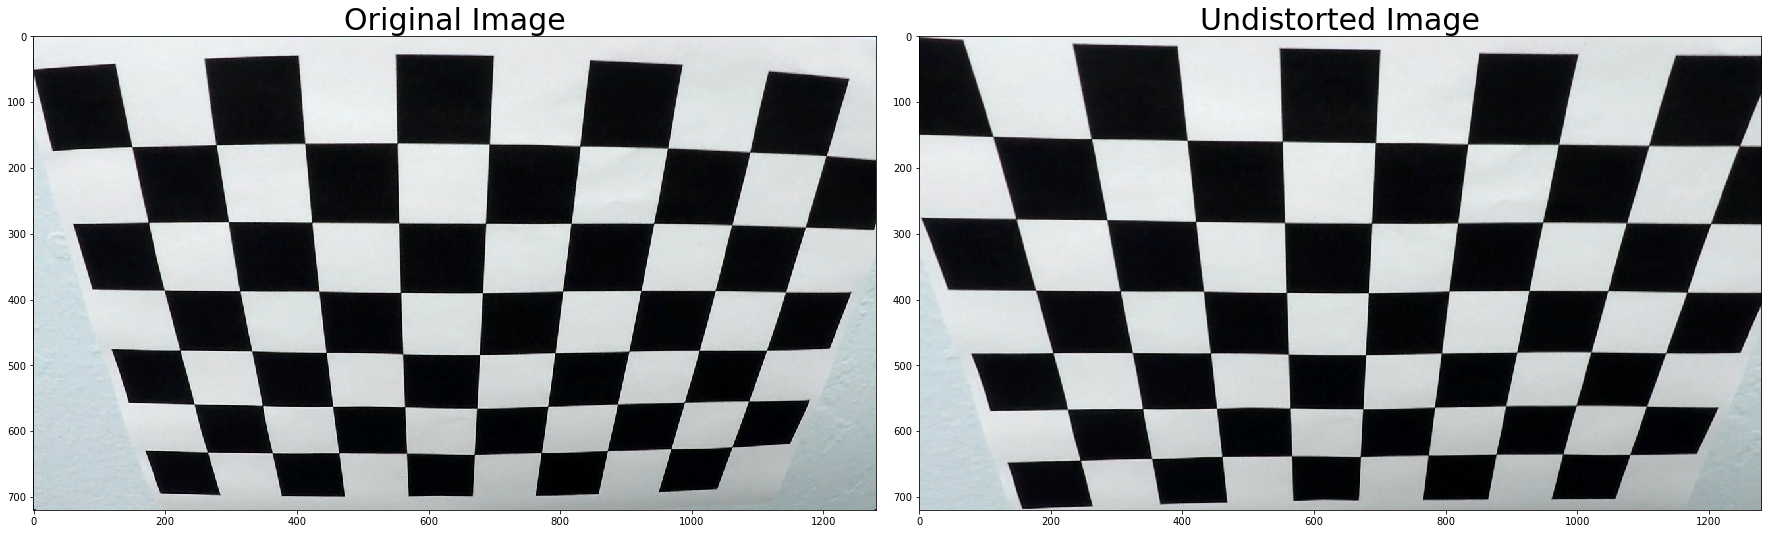

In [6]:
def plot_write_undistored_img():
    # Test undistortion on an image
    fname = 'camera_cal/calibration2.jpg'
    img = cv2.imread(fname)
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

    dst = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('calibration_wide/test_undist.jpg',dst)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist

    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    return mtx, dist
    
mtx, dist = plot_write_undistored_img()

In [7]:
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    img_size = (img.shape[1], img.shape[0])
    
    offset1 = 150 # offset for dst points x value
    #580 -> 575
    src = np.float32([[580,460],[710,460],[1150,720],[150,720]])
    dst = np.float32([[offset1, 0], [img_size[0]-offset1, 0], 
                      [img_size[0]-offset1, img_size[1]], [offset1, img_size[1]]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped, M, Minv

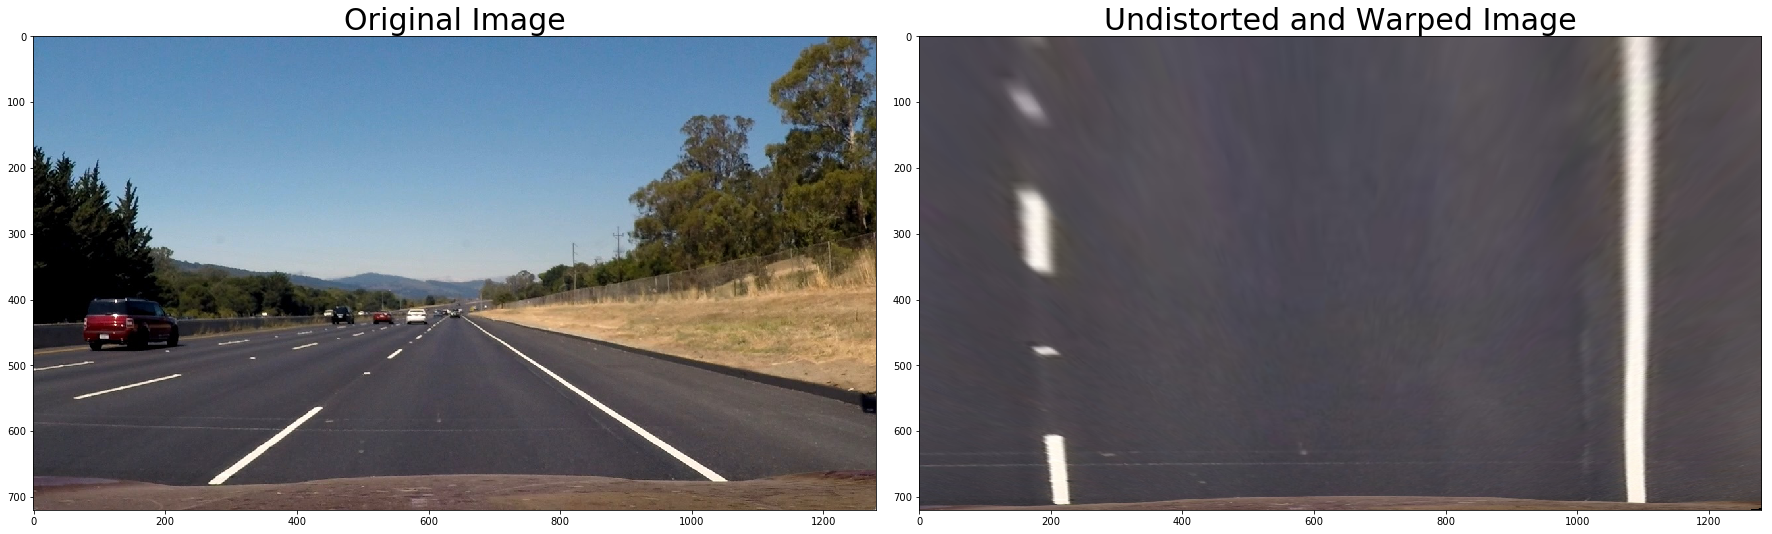

In [8]:
def plot_undistord_warp_img():
    fname = 'test_images/straight_lines2.jpg'
    img_test = cv2.imread(fname)
    rgb = cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB)

    dst_test = cv2.undistort(rgb, mtx, dist, None, mtx)

    top_down, perspective_M, Minv = corners_unwarp(dst_test, nx, ny, mtx, dist)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(rgb)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(top_down)
    ax2.set_title('Undistorted and Warped Image', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plot_undistord_warp_img()

In [9]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx ** 2 + sobely ** 2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag) / 255
    gradmag = (gradmag / scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:, :, 2]
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary

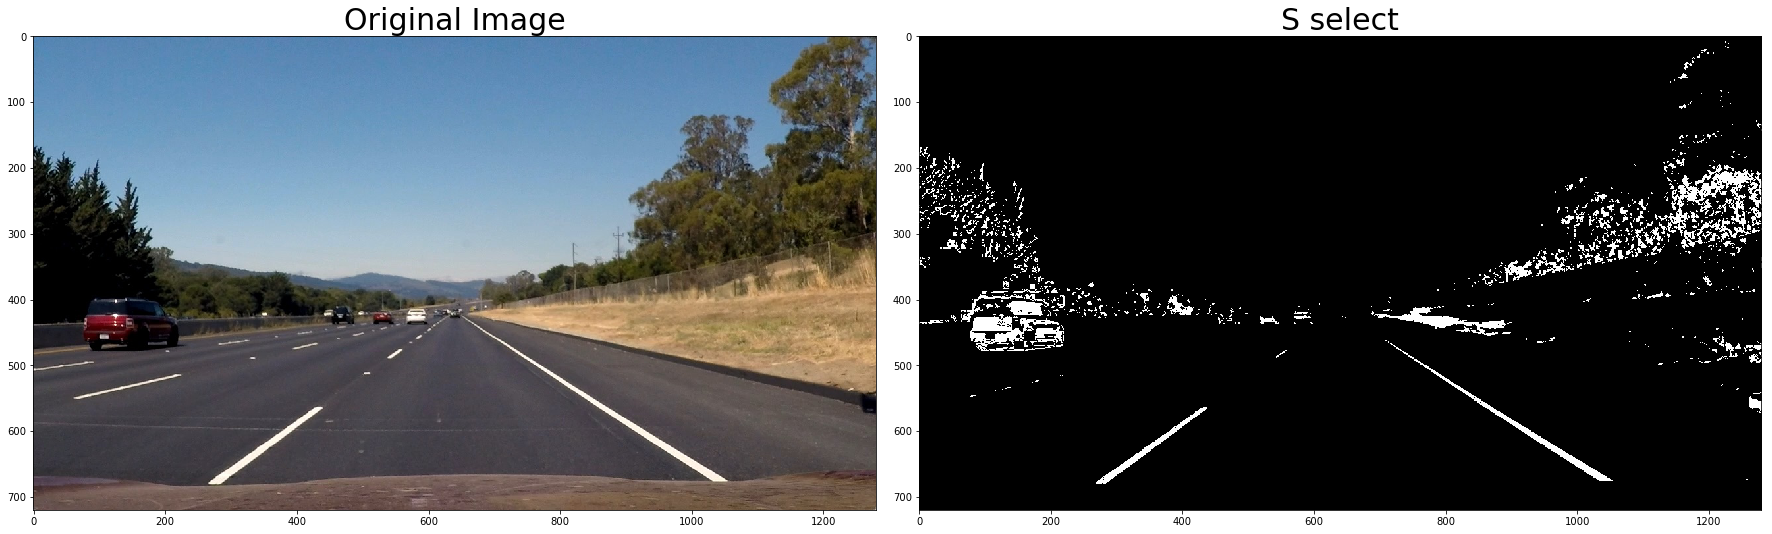

In [10]:
def plot_sls_select():
    fname = 'test_images/straight_lines2.jpg'
    #img_test = cv2.imread(fname)
    img_test = mpimg.imread(fname) 

    res = hls_select(img_test, thresh=(130, 255))

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img_test)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(res, cmap='gray')
    ax2.set_title('S select', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
plot_sls_select()

(720, 1280)


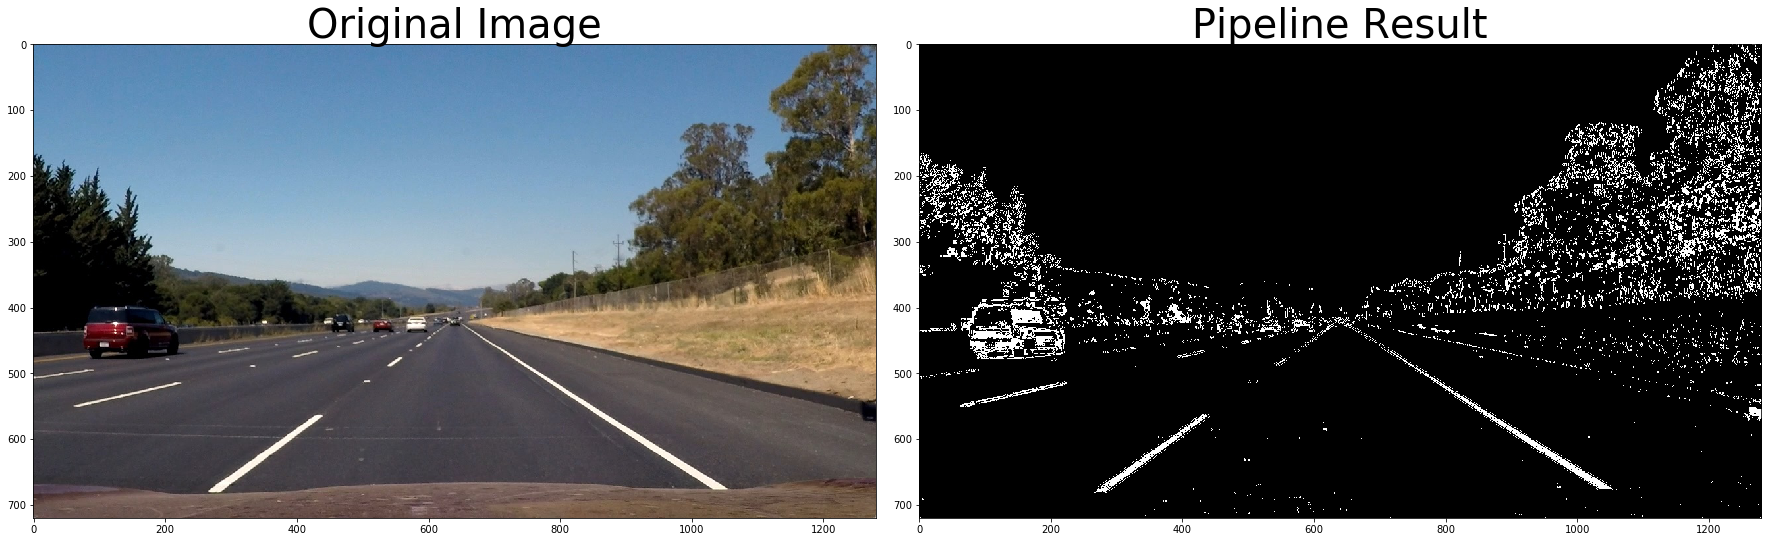

In [11]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 50)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    #combined_binary = cv2.blur(combined_binary, (1,1))
    #combined_binary = cv2.medianBlur(combined_binary,3)
    #combined_binary = cv2.GaussianBlur(combined_binary, (3,3), 0)
    print(combined_binary.shape)
    return combined_binary
    



def plot_combi_hls_sobel():
    fname = 'test_images/straight_lines2.jpg'
    img_test = mpimg.imread(fname) 

    result = pipeline(img_test)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img_test)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(result, cmap='gray')
    ax2.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plot_combi_hls_sobel()
# Grayscale image
# NOTE: we already saw that standard grayscaling lost color information for the lane lines
# Explore gradients in other colors spaces / color channels to see what might work better

#sxbinary = abs_sobel_thresh(img_test, orient='x', sobel_kernel=3, thresh=(20, 100))

#s_binary = hls_select(img_test, thresh=(130, 255))

# Stack each channel to view their individual contributions in green and blue respectively
# This returns a stack of the two binary images, whose components you can see as different colors
#color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

# Combine the two binary thresholds
#combined_binary = np.zeros_like(sxbinary)
#combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# Plotting thresholded images
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
#ax1.set_title('Stacked thresholds')
#ax1.imshow(color_binary)

#ax2.set_title('Combined S channel and gradient thresholds')
#ax2.imshow(combined_binary, cmap='gray')

(720, 1280)


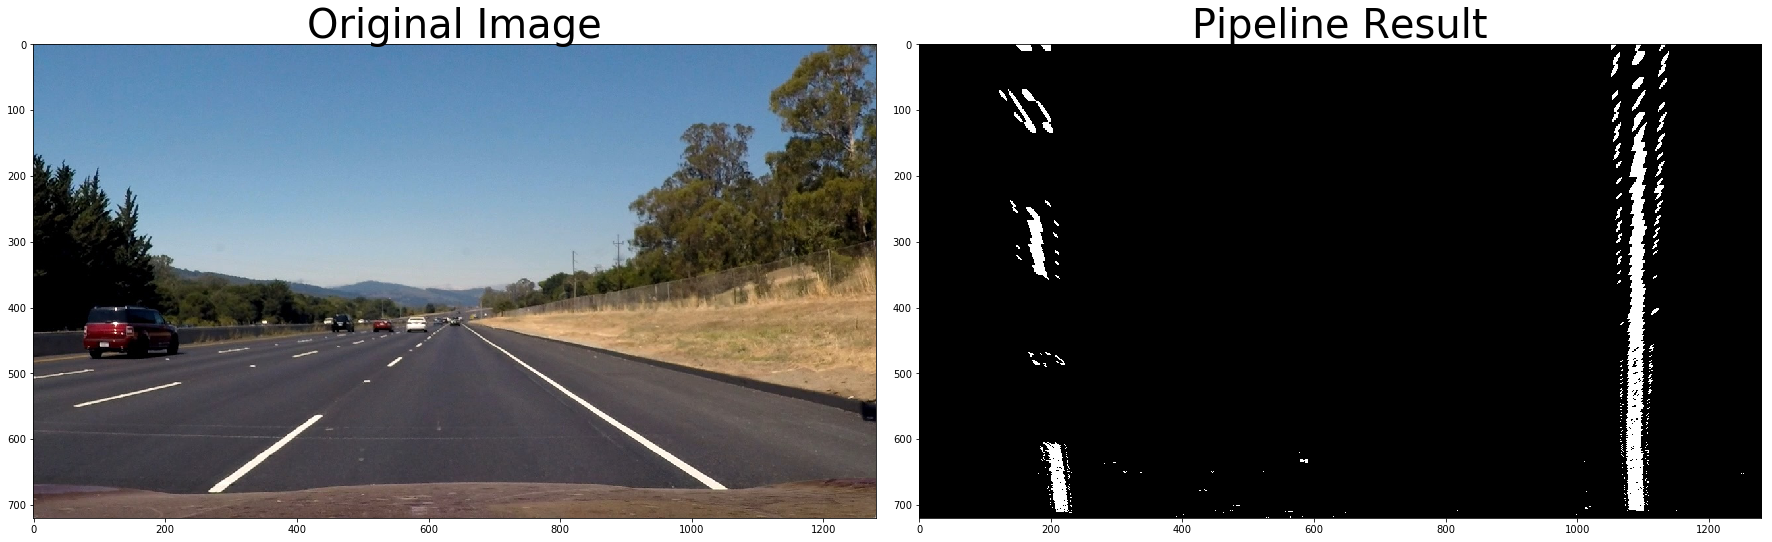

In [12]:
def pipeline_binary_warped(img):
    result = pipeline(img)
    dst_test = cv2.undistort(result, mtx, dist, None, mtx)
    binary_warped, perspective_M, Minv = corners_unwarp(dst_test, nx, ny, mtx, dist)
    return binary_warped, perspective_M, Minv

def plot_preprocessing_warped():
    fname = 'test_images/straight_lines2.jpg'
    #img_test = cv2.imread(fname)
    img_test = mpimg.imread(fname) 

    binary_warped, perspective_M, Minv = pipeline_binary_warped(img_test)
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(img_test)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(binary_warped, cmap='gray')
    ax2.set_title('Pipeline Result', fontsize=40)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
plot_preprocessing_warped()

In [13]:
def find_lanes(nwindows, binary_warped, window_height, leftx_base, rightx_base):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    return left_lane_inds, right_lane_inds

In [14]:
def histogram_starter(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return leftx_base, rightx_base, out_img

In [21]:
def fit_poly(binary_warped, left_lane_inds, right_lane_inds, out_img):
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    return ploty, left_fitx, right_fitx, out_img

In [22]:
def find_fit_poly_pipeline(binary_warped):
    leftx_base, rightx_base, out_img = histogram_starter(binary_warped)

    # Choose the number of sliding windows
    nwindows = 10

    # Set height of windows
    window_height = np.int(binary_warped.shape[0] / nwindows)

    left_lane_inds, right_lane_inds = find_lanes(nwindows, binary_warped, window_height, leftx_base, rightx_base)

    ploty, left_fitx, right_fitx, out_img = fit_poly(binary_warped, left_lane_inds,
                                                                          right_lane_inds, out_img)
    
    return ploty, left_fitx, right_fitx, out_img

(720, 1280)


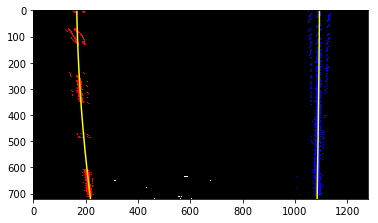

In [23]:
def plot_find_poly():
    fname = 'test_images/straight_lines2.jpg'
    #img_test = cv2.imread(fname)
    img_test = mpimg.imread(fname) 
    
    binary_warped, perspective_M, Minv = pipeline_binary_warped(img_test)
    ploty,left_fitx, right_fitx, out_img = find_fit_poly_pipeline(binary_warped)
    
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
plot_find_poly()

In [24]:
#TODO
def find_curvature(yvals, fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(yvals)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*fit_cr[0])
    return curverad

In [25]:
def process_curvature(ploty, left_fitx, right_fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Calculate the new radii of curvature
    left_curverad = find_curvature(ploty, left_fitx)
    right_curverad = find_curvature(ploty, right_fitx)
    # Now our radius of curvature is in meters
    print(left_curverad, 'm', right_curverad, 'm')
    # Example values: 632.1 m    626.2 m

In [29]:
def print_curvature(path):
    img_test = mpimg.imread(path) 
    
    binary_warped, perspective_M, Minv = pipeline_binary_warped(img_test)
    ploty,left_fitx, right_fitx, out_img = find_fit_poly_pipeline(binary_warped)
    process_curvature(ploty, left_fitx, right_fitx)
    
print_curvature('test_images/straight_lines2.jpg')

(720, 1280)
2580.5229892 m 21879.956961 m


(720, 1280)


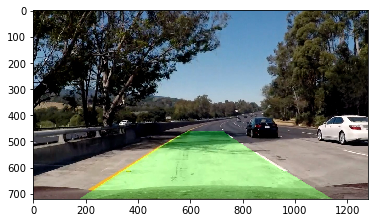

In [36]:
def global_process(filepath):
    img_test = mpimg.imread(filepath) 
    result = pipeline(img_test)
    dst_test = cv2.undistort(result, mtx, dist, None, mtx)
    binary_warped, perspective_M, Minv = corners_unwarp(dst_test, nx, ny, mtx, dist)
    ploty, left_fitx, right_fitx, out_img = find_fit_poly_pipeline(binary_warped)
    
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img_test.shape[1], img_test.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img_test, 1, newwarp, 0.3, 0)
    
    #newwarp = cv2.warpPerspective(out_img, Minv, (img_test.shape[1], img_test.shape[0]))
    
    plt.imshow(result)

global_process('test_images/test5.jpg')